In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thepbordin/indoor-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import torch

# import IPython.display as display
from PIL import Image

from ultralytics import YOLO

In [3]:
class CFG:
    DEBUG = True  # Set to True to make quick experiments
    FRACTION = 0.01 if DEBUG else 1.0
    SEED = 42

    # classes
    CLASSES = [
        'door',
        'cabinetDoor',
        'refrigeratorDoor',
        'window',
        'chair',
        'table',
        'cabinet',
        'couch',
        'openedDoor',
        'pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 1 if DEBUG else 70
    BATCH_SIZE = 4 if DEBUG else 8

    BASE_MODEL = 'yolov9e'  # yolov8n, yolov8s, yolov8m, yolov9e, etc.
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'indoor_objects_{EPOCHS}_epochs'

    OPTIMIZER = 'auto'
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    # CUSTOM_DATASET_DIR = '../data/indoor-object-detection/'  # change path as needed
    ROOT_DIR = os.getcwd()
    OUTPUT_DIR = os.path.join(ROOT_DIR, "hw-3")

In [4]:
CFG.CUSTOM_DATASET_DIR = path

In [5]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [6]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- couch
- openedDoor
- pole
nc: 10
test: /Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/test
train: /Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train
val: /Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/valid



In [7]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')
    plt.show()

/Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train/images/glass-crystal-drawer-pulls.jpg
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (750, 1000, 3) 



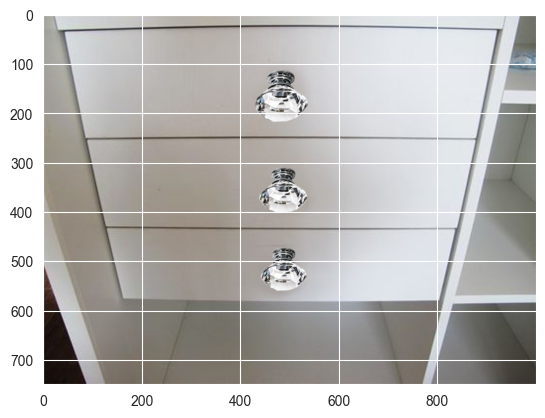

In [8]:
example_image_path = CFG.CUSTOM_DATASET_DIR + '/train/images/glass-crystal-drawer-pulls.jpg'
print(example_image_path)
display_image(example_image_path, print_info = True, hide_axis = False)

In [9]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

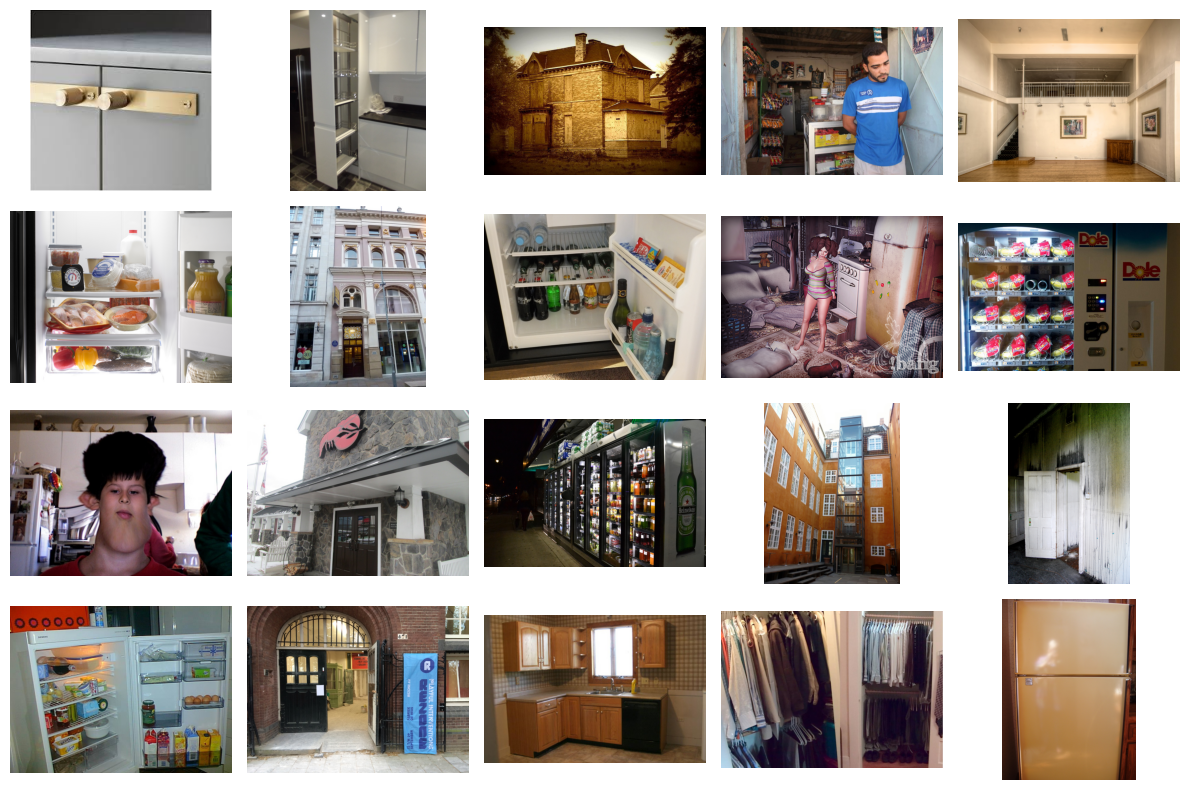

In [10]:
folder_path = CFG.CUSTOM_DATASET_DIR + '/train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [11]:
import cv2
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [12]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1000, 'height': 750, 'channels': 3, 'dtype': dtype('uint8')}

In [13]:
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    mode_path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(mode_path):
        with open(os.path.join(mode_path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(mode_path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,door,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,couch,openedDoor,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


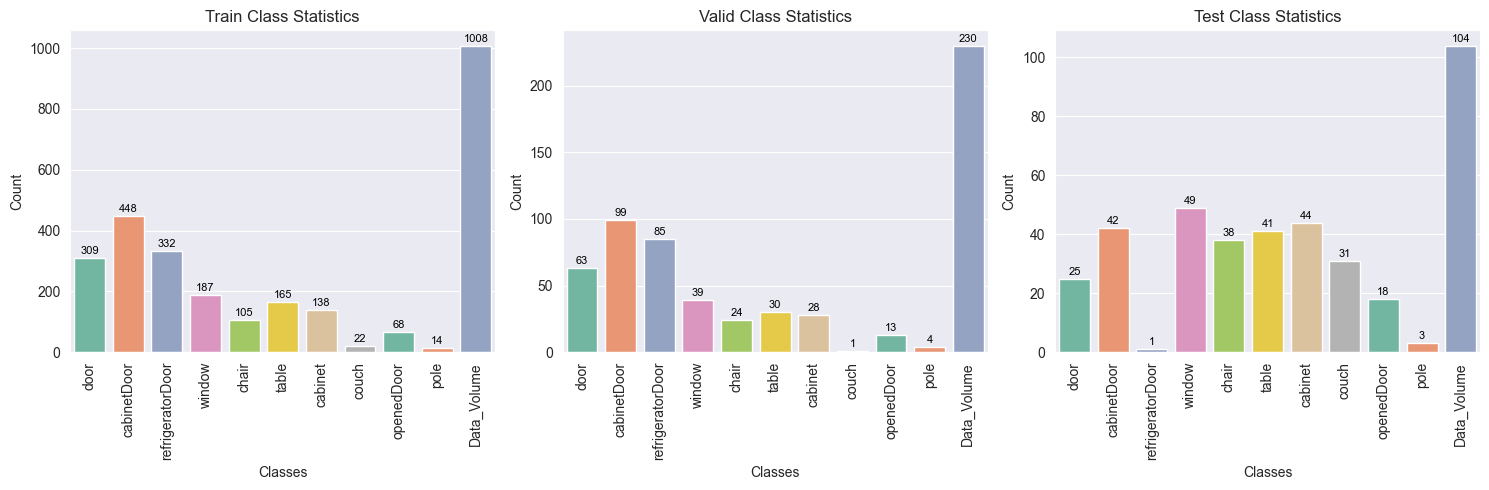

In [14]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [15]:
# Визначення пристрою вручну
if torch.cuda.is_available():
    device = "cuda:0"
    print("Using CUDA (NVIDIA GPU)")
elif torch.backends.mps.is_available():
    device = "mps"
    torch.mps.empty_cache() # Чистим кеш перед запуском
    print("Using MPS (Apple Silicon GPU)")
else:
    device = "cpu"
    print("Using CPU")

Using MPS (Apple Silicon GPU)


In [16]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,  # шлях до зображення або np.ndarray
    classes = [0],                # фільтрація лише за класом "door" (0-й індекс)
    conf = 0.30,                  # поріг впевненості детекції
    device = device,               # CPU (можна: 0 для GPU, [0,1] для мульти-GPU)
    imgsz = (img_properties['height'], img_properties['width']),  # розмір вхідного зображення
    project=CFG.OUTPUT_DIR,
    name="predictions",
    save = True,                  # зберігати результати як зображення з bbox
    save_txt = True,              # зберігати YOLO-формат у .txt
    save_conf = True,             # зберігати значення впевненості у .txt
    exist_ok = True,              # не створювати нову папку якщо вже існує
)


WARNING ⚠️ imgsz=[750, 1000] must be multiple of max stride 32, updating to [768, 1024]
image 1/1 /Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train/images/glass-crystal-drawer-pulls.jpg: 768x1024 (no detections), 209.4ms
Speed: 10.7ms preprocess, 209.4ms inference, 49.0ms postprocess per image at shape (1, 3, 768, 1024)
Results saved to /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/predictions
0 label saved to /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/predictions/labels


In [17]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9e.pt
Epochs:  1
Batch:  4


In [18]:
model = YOLO('yolov9e.yaml')

In [19]:
### train
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    imgsz = (img_properties['height'], img_properties['width']),
    pretrained=CFG.BASE_MODEL_WEIGHTS,
    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,

    project=CFG.OUTPUT_DIR,
    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    amp = True,
    exist_ok = True,
    resume = False,
    device = device, #  [0,1]
    verbose = False,
)

New https://pypi.org/project/ultralytics/8.3.133 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.132 🚀 Python-3.12.2 torch-2.7.0 MPS (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/data.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=0.01, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(750, 1000), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9e.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov9e_indoor_

train: Scanning /Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/train/labels.cache... 10 images, 2 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 449.3±254.6 MB/s, size: 290.6 KB)



val: Scanning /Users/vdubyna/.cache/kagglehub/datasets/thepbordin/indoor-object-detection/versions/1/valid/labels.cache... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<?, ?it/s]


Plotting labels to /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      26.2G       4.25      14.67      4.201          3       1024: 100%|██████████| 3/3 [06:21<00:00, 127.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [09:41<00:00, 20.04s/it]


                   all        230       1289   0.000167     0.0147   0.000101   4.14e-05

1 epochs completed in 0.270 hours.
Optimizer stripped from /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/weights/last.pt, 117.3MB
Optimizer stripped from /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/weights/best.pt, 117.3MB

Validating /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/weights/best.pt...
Ultralytics 8.3.132 🚀 Python-3.12.2 torch-2.7.0 MPS (Apple M1 Pro)
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [04:05<00:00,  8.46s/it]


                   all        230       1289   0.000174     0.0147   0.000102   3.57e-05
Speed: 13.3ms preprocess, 974.1ms inference, 0.0ms loss, 48.4ms postprocess per image
Results saved to /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x982e9aa80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

In [23]:
# Export the model
# The 'fraction' argument is not supported for ONNX export.
# It might be present in model.overrides from previous settings (e.g., INT8 calibration).
# We temporarily remove it to prevent the AssertionError.
_fraction_backup = None
if hasattr(model, 'overrides') and isinstance(model.overrides, dict) and 'fraction' in model.overrides:
    print("Note: Temporarily removing 'fraction' from model.overrides for ONNX export.")
    _fraction_backup = model.overrides.pop('fraction')

model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
    project=CFG.OUTPUT_DIR,
    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
)

Note: Temporarily removing 'fraction' from model.overrides for ONNX export.
Ultralytics 8.3.132 🚀 Python-3.12.2 torch-2.7.0 CPU (Apple M1 Pro)
WARNING ⚠️ imgsz=[750, 1000] must be multiple of max stride 32, updating to [768, 1024]
YOLOv9e summary (fused): 279 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/weights/best.pt' with input shape (1, 3, 768, 1024) BCHW and output shape(s) (1, 14, 16128) (111.9 MB)

ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: export success ✅ 4.0s, saved as '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/weights/best.onnx' (219.5 MB)

Export complete (7.2s)
Results saved to /Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/weights
Predict:         yolo predict task=detect model=/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homewor

'/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/weights/best.onnx'

In [25]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/confusion_matrix.png',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/results.png',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/P_curve.png',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/F1_curve.png',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/confusion_matrix_normalized.png',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/R_curve.png',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/PR_curve.png',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/labels_correlogram.jpg',
 '/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov

/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/F1_curve.png


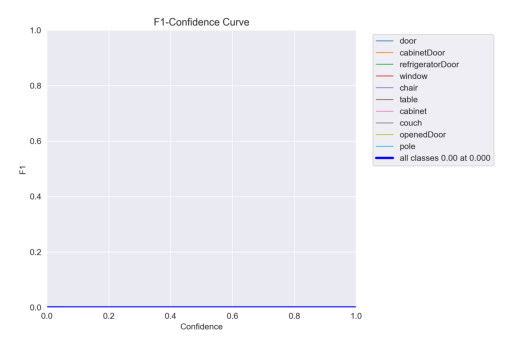



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/PR_curve.png


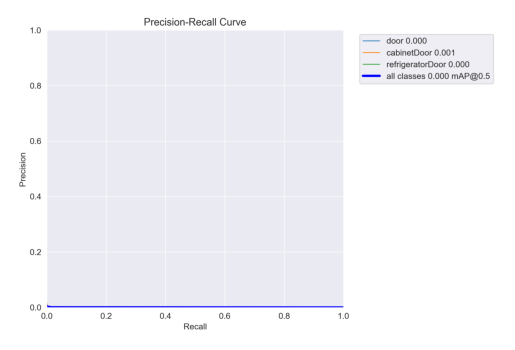



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/P_curve.png


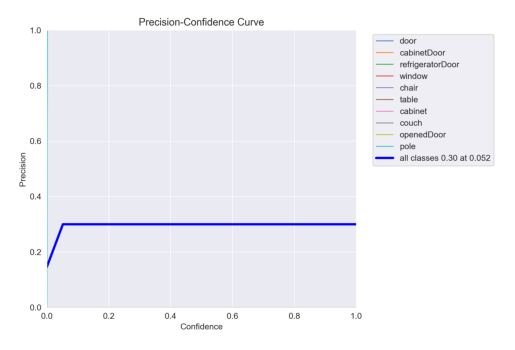



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/R_curve.png


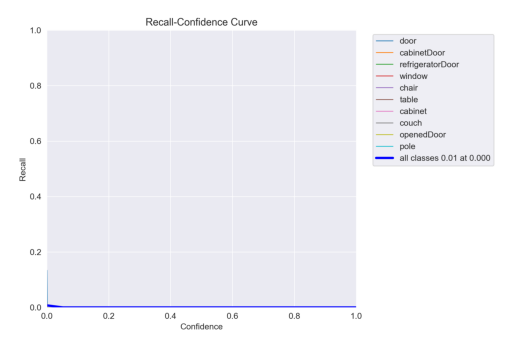



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/confusion_matrix.png


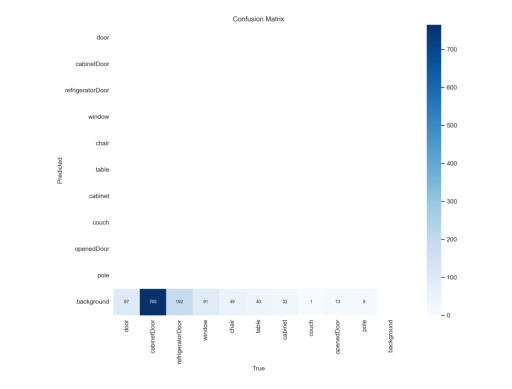



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/confusion_matrix_normalized.png


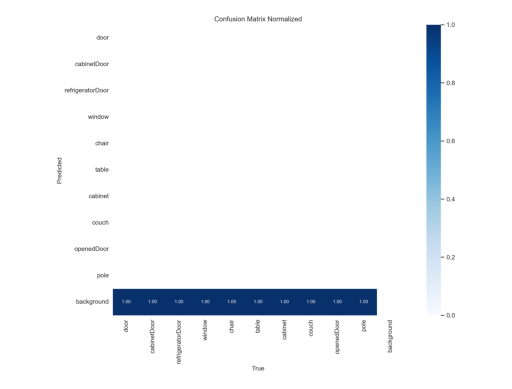



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/labels.jpg


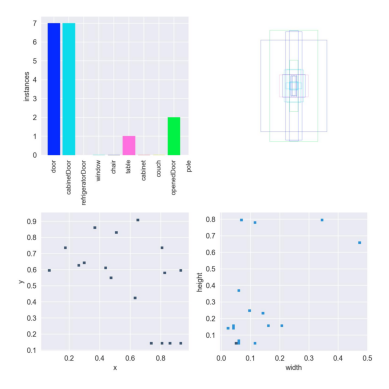



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/labels_correlogram.jpg


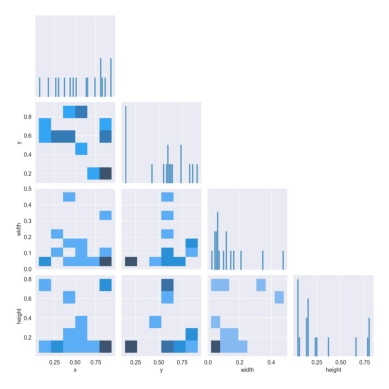



/Users/vdubyna/Workspace/GO__IT/go-it-dl-nlp/homeworks/outputs/yolov9e_indoor_objects_1_epochs/results.png


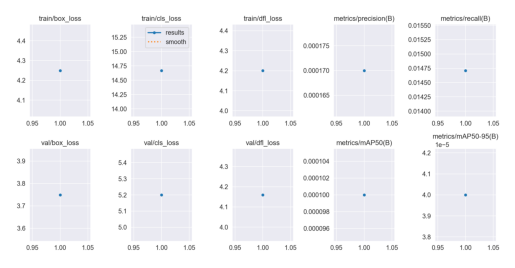

In [26]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')